使用设备: cuda
数据集已存在，跳过下载

Epoch 1/5
--------------------------------------------------
Batch 5/80, Loss: 0.9003
Batch 10/80, Loss: 1.0500
Batch 15/80, Loss: 0.9148
Batch 20/80, Loss: 0.9755
Batch 25/80, Loss: 0.8818
Batch 30/80, Loss: 0.7815
Batch 35/80, Loss: 0.9848
Batch 40/80, Loss: 1.6459
Batch 45/80, Loss: 0.9420
Batch 50/80, Loss: 0.9241
Batch 55/80, Loss: 1.0500
Batch 60/80, Loss: 0.9104
Batch 65/80, Loss: 0.7800
Batch 70/80, Loss: 1.1064
Batch 75/80, Loss: 1.1399
Batch 80/80, Loss: 1.0731
Epoch 1 平均损失: 1.0221, 当前学习率: 0.000500
保存最优模型（损失：1.0221）

Epoch 2/5
--------------------------------------------------
Batch 5/80, Loss: 1.0374
Batch 10/80, Loss: 0.7093
Batch 15/80, Loss: 0.6779
Batch 20/80, Loss: 0.6369
Batch 25/80, Loss: 0.7433
Batch 30/80, Loss: 0.9841
Batch 35/80, Loss: 0.7128
Batch 40/80, Loss: 1.2244
Batch 45/80, Loss: 1.5415
Batch 50/80, Loss: 1.1696
Batch 55/80, Loss: 0.5782
Batch 60/80, Loss: 0.9847
Batch 65/80, Loss: 0.7656
Batch 70/80, Loss: 0.7164
Batch 75/80, Loss: 

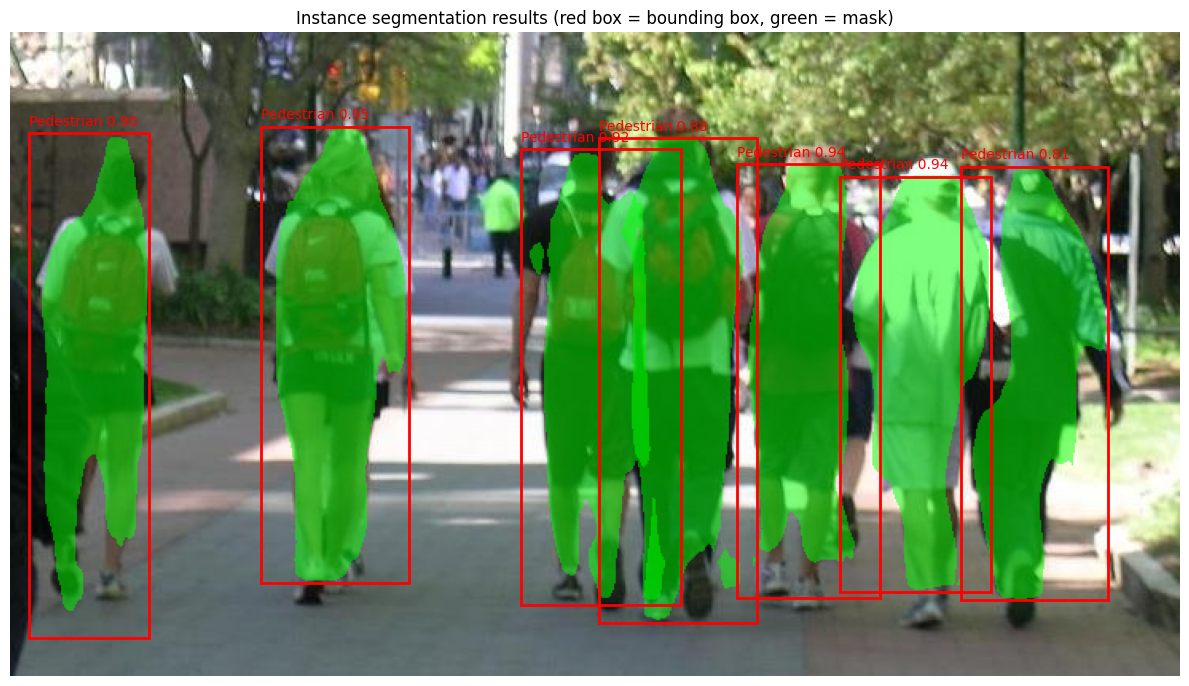

In [ ]:
import os
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import requests
import zipfile
import warnings
warnings.filterwarnings('ignore')

# ======================== 1. 数据集下载与加载 ========================
def download_pennfudanped(root="./data"):
    """自动下载PennFudanPed数据集"""
    os.makedirs(root, exist_ok=True)
    data_path = os.path.join(root, "PennFudanPed")
    if os.path.exists(data_path):
        print("数据集已存在，跳过下载")
        return data_path
    
    # 下载数据集
    url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
    zip_path = os.path.join(root, "PennFudanPed.zip")
    print("正在下载PennFudanPed数据集...")
    response = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    # 解压
    print("正在解压数据集...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(root)
    os.remove(zip_path)
    print("数据集准备完成")
    return data_path

class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        # 加载图片和掩码
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        # 提取不同实例的掩码
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # 去除背景(0)
        masks = mask == obj_ids[:, None, None]
        
        # 生成边界框
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        # 转换为Tensor格式
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)  # 行人=1
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# ======================== 2. 数据增强与预处理 ========================
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

class ToTensor:
    def __call__(self, img, target):
        img = F.to_tensor(img)
        return img, target

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            w = image.shape[-1]
            bbox = target["boxes"]
            bbox[:, [0, 2]] = w - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(p=0.5))
    return Compose(transforms)

# ======================== 3. 模型构建 ========================
def get_model(num_classes):
    """构建Mask R-CNN模型（预训练+自定义分类头）"""
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # 替换边界框预测头
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # 替换掩码预测头
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

# ======================== 4. 训练函数（优化版） ========================
def train_model(model, data_loader, device, optimizer, lr_scheduler, num_epochs=5):
    model.train()
    best_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        total_loss = 0.0
        
        for i, (images, targets) in enumerate(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # 前向传播
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # 反向传播
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            total_loss += losses.item()
            
            # 打印训练进度
            if (i+1) % 5 == 0:
                print(f"Batch {i+1}/{len(data_loader)}, Loss: {losses.item():.4f}")
        
        # 更新学习率
        lr_scheduler.step()
        
        # 计算平均损失
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1} 平均损失: {avg_loss:.4f}, 当前学习率: {optimizer.param_groups[0]['lr']:.6f}")
        
        # 保存最优模型
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "mask_rcnn_pedestrian_best.pth")
            print(f"保存最优模型（损失：{best_loss:.4f}）")
    
    # 保存最终模型
    torch.save(model.state_dict(), "mask_rcnn_pedestrian_final.pth")
    print("\n模型已保存：mask_rcnn_pedestrian_best.pth（最优） | mask_rcnn_pedestrian_final.pth（最终）")
    return model

# ======================== 5. 推理与可视化 ========================
def visualize_prediction(img, predictions, threshold=0.5):
    """可视化预测结果（原图+边界框+掩码）"""
    # 转换为numpy格式
    img_np = img.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_np)
    ax = plt.gca()
    
    # 过滤低置信度预测
    masks = predictions[0]['masks']
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    
    # 只保留置信度高于阈值的结果
    keep = scores > threshold
    masks = masks[keep]
    boxes = boxes[keep]
    scores = scores[keep]
    
    # 绘制边界框和掩码
    for box, mask, score in zip(boxes, masks, scores):
        # 绘制边界框
        x1, y1, x2, y2 = box.cpu().numpy()
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'Pedestrian {score:.2f}', color='red', fontsize=10)
        
        # 绘制掩码（绿色半透明）
        mask_np = mask[0].cpu().detach().numpy()
        mask_np = (mask_np > 0.5).astype(np.uint8)
        # 叠加掩码到原图
        img_np[mask_np == 1] = img_np[mask_np == 1] * 0.5 + np.array([0, 255, 0]) * 0.5
    
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Instance segmentation results (red box = bounding box, green = mask)")
    plt.tight_layout()
    plt.show()

# ======================== 6. 主流程（一键运行） ========================
def main():
    # 1. 配置环境
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"使用设备: {device}")
    
    # 2. 准备数据集
    data_root = download_pennfudanped()
    dataset = PennFudanDataset(data_root, get_transform(train=True))
    dataset_test = PennFudanDataset(data_root, get_transform(train=False))
    
    # 划分训练集和测试集
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-10])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])
    
    # 自定义collate_fn，适配实例分割的不规则批量
    def collate_fn(batch):
        return tuple(zip(*batch))
    
    # 创建数据加载器
    data_loader = DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0,
        collate_fn=collate_fn
    )
    
    # 3. 构建模型（类别数：1个行人 + 1个背景 = 2）
    num_classes = 2
    model = get_model(num_classes)
    model.to(device)
    
    # 4. 配置优化器和学习率调度器
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=0.0005, weight_decay=0.0001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    
    # 5. 训练模型
    model = train_model(model, data_loader, device, optimizer, lr_scheduler, num_epochs=5)
    
    # 6. 推理测试
    model.eval()
    # 取测试集中的第一张图片
    test_img, _ = dataset_test[0]
    test_img = test_img.to(device)
    
    # 预测
    with torch.no_grad():
        predictions = model([test_img])
    
    # 可视化结果
    visualize_prediction(test_img, predictions, threshold=0.7)

if __name__ == "__main__":
    main()